# Preliminaries
Data preprocessing in order to feed our CNN. The following considerations are taking into account:

* To read the data, Uproot is faster than Pyroot. However, we do not know if the software can be installed properly at CUDA and CIEMAT computers. 
* Software to reduce the size of the images, but keeping the signal and important caracteristics.
* A method to store this data efficiently. Probably png or csv files.

# READ DATA

In [1]:
########## dependencies ###########
import uproot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file = uproot.open("0-RecoFull-Parser.root")
print("the data contains in the file has the following format: ",file[file.keys()[0]].keys())
print("We can access the data using")

the data contains in the file has the following format:  [b'anatree;15', b'anatree;14']
We can access the data using


In [3]:
tree=file["analysistree"]["anatree"] 
tree.keys()

[b'Run',
 b'Subrun',
 b'EventNumberInRun',
 b'EventTimeSeconds',
 b'EventTimeNanoseconds',
 b'IsData',
 b'RecoWaveforms_NumberOfChannels',
 b'RecoWaveform_Channel',
 b'RecoWaveform_NTicks',
 b'RecoWaveform_NumberOfTicksInAllChannels',
 b'RecoWaveform_Tick',
 b'RecoWaveform_ADC',
 b'NumberOfHits',
 b'Hit_TPC',
 b'Hit_View',
 b'Hit_Channel',
 b'Hit_PeakTime',
 b'Hit_ChargeSummedADC',
 b'Hit_ChargeIntegral',
 b'Hit_Amplitude',
 b'Hit_StartTime',
 b'Hit_EndTime',
 b'Hit_Width',
 b'Hit_GoodnessOfFit',
 b'Hit_FitParameter_Amplitude',
 b'Hit_FitParameter_Offset',
 b'Hit_FitParameter_Tau1',
 b'Hit_FitParameter_Tau2',
 b'Hit_Multiplicity',
 b'Hit_trueID',
 b'Hit_trueEnergyMax',
 b'Hit_trueEnergyFraction',
 b'Hit_TrackID',
 b'Hit_ClusterID',
 b'NumberOfClusters',
 b'ClusterID',
 b'Cluster_NumberOfHits',
 b'Cluster_View',
 b'Cluster_ChargeIntegral',
 b'Cluster_ChargeIntegralAveragePerHit',
 b'Cluster_StartChannel',
 b'Cluster_StartTick',
 b'Cluster_EndChannel',
 b'Cluster_EndTick',
 b'Cluster_Sta

In [4]:
print(tree.array(b'RecoWaveform_Channel')[98].shape) ## 1229 channels
print(tree.array( b'RecoWaveform_NTicks')[98]) ## each channel 1667 ticks , the explanatory pdf is wrong!

(1229,)
[1667 1667 1667 ... 1667 1667 1667]


* It seems that theere are 1229 channels and 1667 ticks. 
* probably first view from 0 to 279 and second the rest. 

In [5]:
ADC = tree.array( b'RecoWaveform_ADC')
NChannel=tree.array(b'RecoWaveforms_NumberOfChannels')
Nticks=tree.array(b'RecoWaveform_NumberOfTicksInAllChannels')
NTracks=tree.array(b'NumberOfTracks')
w , h = int(NChannel[0]) , int(Nticks[0]/NChannel[0])
print(w,h)

1229 1667


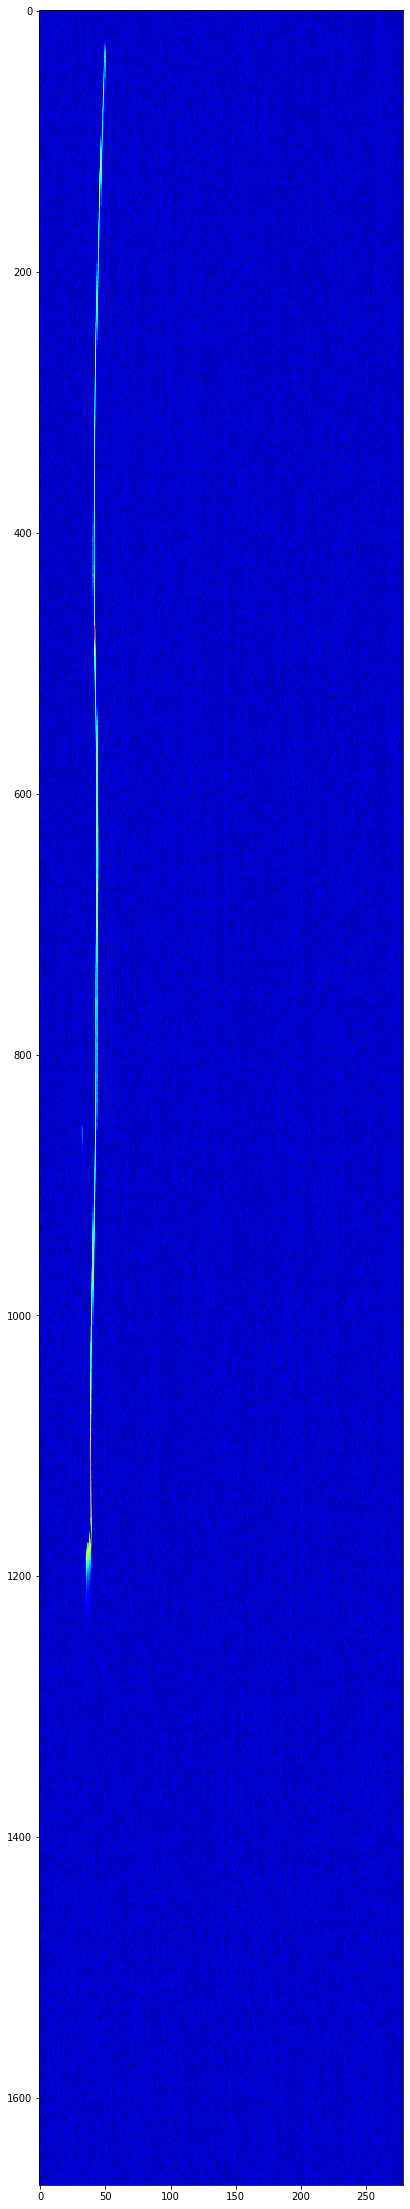

In [6]:
im=ADC[56].reshape((w,h))
v1=im[0:279,:]
fig = plt.figure(frameon = False)
plt.imshow(v1.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(30, 40)##grey scale
plt.savefig('big.png')

In [7]:
def maxpool(im, h, w):
    #####the imputs#####
    # im.shape must be a matrix of(width, height)
    # w and h are the output weight and height respectively .
    
#### preliminaries###
    h_step=im.shape[0]//h
    w_step=im.shape[1]//w
    #print("we have lost", (im.shape[1]%w)*(im.shape[0]%h), "pixels along the way")
    
    reduced_im=np.zeros((h,w)) ##the new reduced matrix is initialized with zeros
    
    
    ########The algorithm#########
    for i in range(0,h): #loop over h
        for j in range(0,w): #loop over w
            pool=im[i*h_step:h_step*(i+1),j*w_step:(j+1)*w_step]
            reduced_im[i,j]=np.max(pool)
            
            
    return reduced_im

In [8]:
def maxpoolmod(im, h, w):
    # observacions, modifications to account for issues regarding h_step ~ 1
    #####the imputs#####
    # im.shape must be a matrix of(width, height)
    # w and h are the output weight and height respectively .
    
#### preliminaries###
    h_step=im.shape[0]//h
    w_step=im.shape[1]//w
    #print("we have lost", (im.shape[1]%w)*(im.shape[0]%h), "pixels along the way")
    
    reduced_im=np.zeros((h,w)) ##the new reduced matrix is initialized with zeros
    extra_pixels=im.shape[0]-(im.shape[0]//h)*h
    print(extra_pixels)
    loss_h = (im.shape[0]//h *h)/im.shape[0] ##the percented of the image that we will lose
    print('we are loosing without processing', 1-loss_h ,'pixels')
    count=0
    ##########The algorithm##########
    for i in range(0,h): #loop over h
        for j in range(0,w): #loop over w
            r=np.random.uniform()
            #print(count,r,':',i,j)
            if r>extra_pixels/h/w and count<extra_pixels:
                pool=im[i*h_step+count:h_step*(i+1)+count,(j)*w_step:(j+1)*w_step]
                reduced_im[i,j]=np.max(pool)
            if r<extra_pixels/h/w and count<extra_pixels:
                pool=im[i*h_step+count:h_step*(i+1)+count,(j)*w_step:(j+1)*w_step]
                reduced_im[i,j]=np.max(pool)
                count=count+1     
    return reduced_im ,count

In [9]:
h=80
v1.shape[0]-v1.shape[0]//h*h
(57+36)*3

279

39
we are loosing without processing 0.13978494623655913 pixels
39


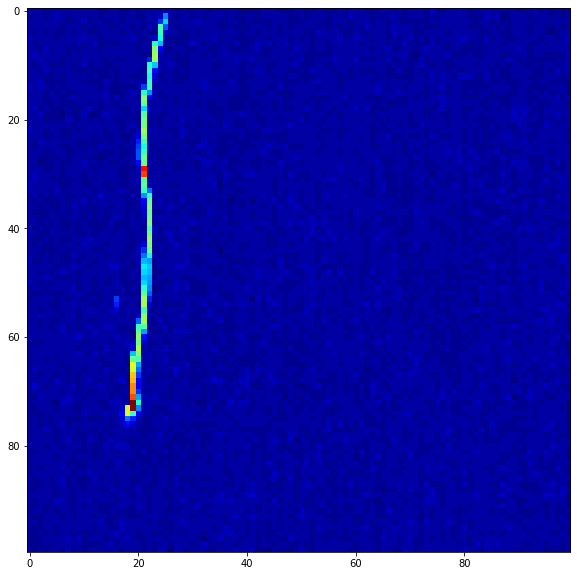

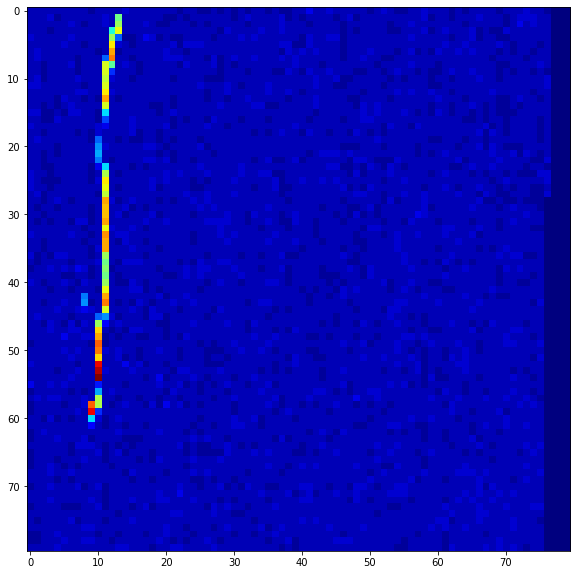

In [10]:
v1red=maxpool(v1,100,100)
fig = plt.figure(frameon = False)
plt.imshow(v1red.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(10, 10) ##grey scale
plt.savefig('small.png')

v1redmu, count=maxpoolmod(v1,80,80)
print(count)
fig = plt.figure(frameon = False)
plt.imshow(v1redmu.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(10, 10) ##grey scale
plt.savefig('small.png')

# Observaciones:
* the algorithm only works approximately if h and w are <<< im.shape . Otherwise, the algorithm will cut the image. 

* In order to account for this issue, what can be done is 

    1. reduce only the big axis, the one with
    2. modify the algorithm 

v1red=maxpool(v1,200,200)
fig = plt.figure(frameon = False)
plt.imshow(v1red.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(10, 10) ##grey scale
plt.savefig('small.png')

v1red=maxpoolmod(v1,200,200)
fig = plt.figure(frameon = False)
plt.imshow(v1red.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(10, 10) ##grey scale
plt.savefig('small.png')

# Considerations: file size
In order to save memory, our data set must me made of these images. It can be stored in a cv file, or in a root tree. We will see how efficient is the root tree. Options: 

* use csv files with delimiter ',' : 200x200 img is ~900K
* use numpy.save : 200x200 img is ~300K
* use ROOT trees: 200x200 img is ~33K
* use png images: The data is not properly conserved, we do not have the numerical values but rather a png image that approximate this values. 

As far as disc memory is concerned, probably the best option to tackle this problem is using ROOT trees.

In [11]:
np.save('savenp',v1red) ### 
np.savetxt("foo.csv", v1red, delimiter=",")

In [12]:
from ROOT import TFile, TTree
import numpy as np

f = TFile('example.root', 'recreate')
t = TTree('mytree', 'example tree')

t.Branch('myarray', v1red, 'myarray[200][200]/D')
print(v1red.flatten().shape)

t.Fill()

f.Write()
f.Close()

Welcome to JupyROOT 6.18/00
(10000,)


In [13]:
import ROOT
import numpy as np

tfile = ROOT.TFile("example.root")
ttree = tfile.mytree

nentries = 1
for i in range(nentries):
    ttree.GetEntry(i)
    print(ttree.myarray)


<Double_t buffer, size 40000>


In [14]:
v1red.flatten()[0]

2.0

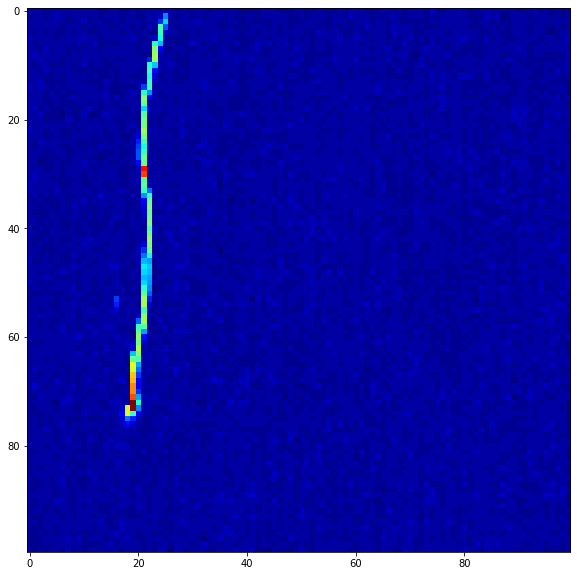

In [16]:
fig = plt.figure(frameon = False)
plt.imshow(v1red.flatten().reshape(100,100).T,cmap = 'jet',interpolation='none')
fig.set_size_inches(10, 10) ##grey scale
plt.savefig('small.png')

In [22]:
file=uproot.open("example.root")
tree=file[b'mytree;1']

In [23]:
im=tree.array( b'myarray')[0]

In [25]:
print(im.shape)
print(v1red.shape)

(200, 200)
(100, 100)


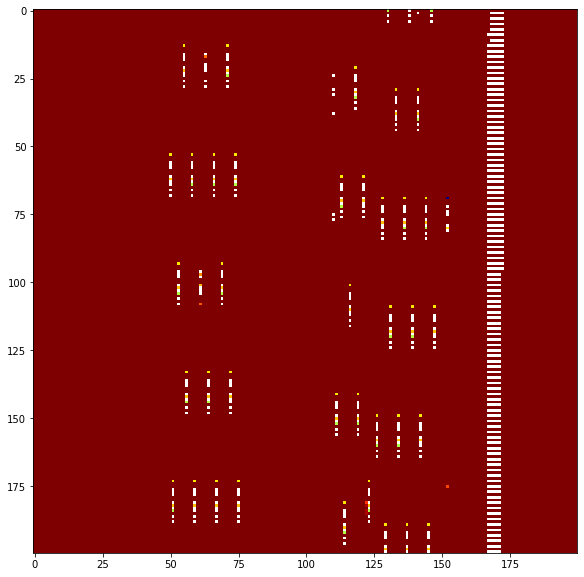

In [26]:
fig = plt.figure(frameon = False)
plt.imshow(im.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(10, 10) ##grey scale
plt.savefig('small.png')

This reduction algorithim must be uploaded into lxplus and then download the reduced data. Consequently, 1000 $e^{-}$ and 1000 $\mu^{-}$ waveforms must be around 60MB and 1 million waveforms 30 GB. I believe this 30 GB is a very reasonable number. 

We have to see if the image reduction algorithm also works for electrons. 

In [27]:
file = uproot.open("/Users/dan/CIEMAT/ROOT/ROOT_try/electrons/0-RecoFull-Parser.root")
tree=file["analysistree"]["anatree"] 

In [28]:
ADC = tree.array( b'RecoWaveform_ADC')
NChannel=tree.array(b'RecoWaveforms_NumberOfChannels')
Nticks=tree.array(b'RecoWaveform_NumberOfTicksInAllChannels')
NTracks=tree.array(b'NumberOfTracks')
w , h = int(NChannel[0]) , int(Nticks[0]/NChannel[0])
print(w,h)

1280 1667


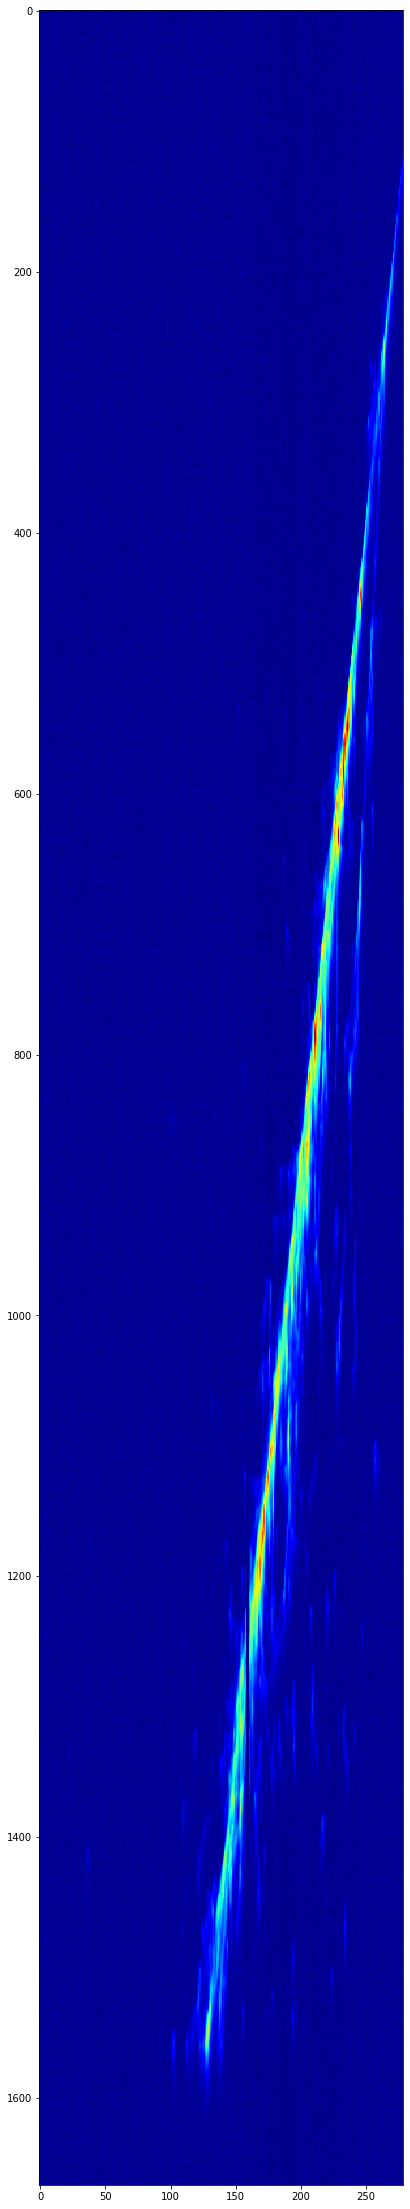

In [33]:
im=ADC[61].reshape((w,h))
v1=im[0:279,:]
fig = plt.figure(frameon = False)
plt.imshow(v1.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(30, 40) ##grey scale
plt.savefig('big.png')

79
we are loosing without processing 0.2831541218637993 pixels
66


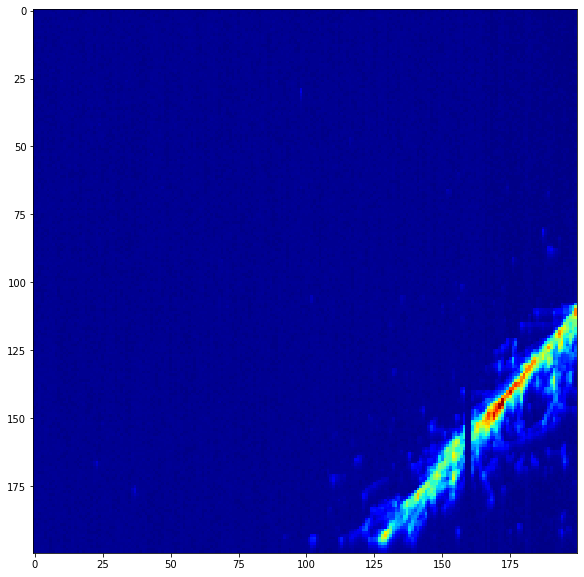

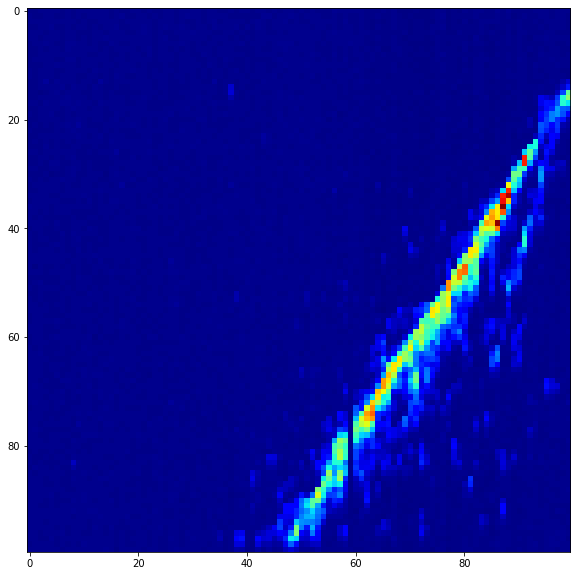

In [37]:
v1red=maxpool(v1,200,200)
fig = plt.figure(frameon = False)
plt.imshow(v1red.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(10, 10) ##grey scale
plt.savefig('small.png')

v1rede, count=maxpoolmod(v1,100,100)
print(count)
fig = plt.figure(frameon = False)
plt.imshow(v1rede.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(10, 10) ##grey scale
plt.savefig('small.png')

# Conclusions

Now our data is ready to feed our Deep Neural networks.

Conviene reducir a 100x100 pixeles

* bloque convolutivo
 1. kernel(5...7...9)
 2. bajar después+pooling (2x2)
* salida
 1. confusion matrix